<a href="https://colab.research.google.com/github/nabhgarg/Forecasting-and-Comparing-time-series-of-frequency-of-road-accidents-/blob/main/TimeSeries_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Upload Datasets**

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving final_dataset_of_india - Copy.csv to final_dataset_of_india - Copy.csv


**Original Data Visualization**

,t
Year,
2001.000000,27039
2001.083333,26694
2001.166667,28284
2001.250000,27921
2001.333333,29978


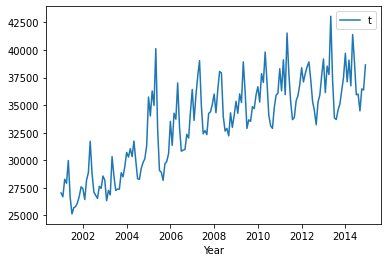

In [ ]:
df = pd.read_csv('final_dataset_of_india - Copy.csv')
df = df.rename(columns = {'to_be_index' : 'Year'})
df = df.set_index('Year')
df.plot()
df.head()

**Tranform dataset to an SL problem**

In [ ]:
df.insert(1, "t-1", 1) 
df['t-1'] = df['t'].shift(1)
df.head()

,t,t-1
Year,,
2001.000000,27039,NaN
2001.083333,26694,27039.0
2001.166667,28284,26694.0
2001.250000,27921,28284.0
2001.333333,29978,27921.0


**Useful Functions**

In [ ]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values


# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

**Forecasting & Error Calculation**

>expected=37531.0, predicted=37621.0
>expected=39699.0, predicted=39908.8
>expected=37115.0, predicted=37111.6
>expected=39085.0, predicted=39081.9
>expected=36747.0, predicted=36833.5
>expected=41404.0, predicted=41043.6
>expected=38909.0, predicted=38998.6
>expected=35946.0, predicted=35941.0
>expected=36003.0, predicted=36005.4
>expected=34485.0, predicted=34525.6
>expected=36478.0, predicted=36403.9
>expected=36378.0, predicted=36416.8
Mean Absolute Error: 83.623
Percent error: 0.251


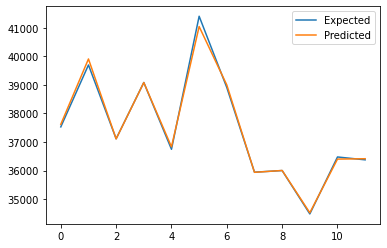

In [ ]:
values = df.values
# transform the time series data into supervised learning
data1 = series_to_supervised(values)
# evaluate
mae, y, yhat = walk_forward_validation(data1, 12)
print('Mean Absolute Error: %.3f' % mae)
avg = df['t'].mean()
percent_error = (mae/avg)*100
print('Percent error: %0.3f' %percent_error)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [ ]:
avg = df['t'].mean()
percent_error = (mae/avg)*100
print(percent_error)

0.25766778882244457
